# Imports

In [118]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
3
NVIDIA GeForce RTX 3090


In [119]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, export_dynamic_orbits_html
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import jacobi_constant, calculate_errors_per_orbit
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, calculate_closest_feature_distances, find_nearest_orbits_batch, calculate_pairwise_distances
from orbit_generation.latent_space import plot_2d_latent_space, plot_combined_2d_latent_space, reduce_dimensions_latent_space, compute_centroids, interpolate_sample
from orbit_generation.convergence import process_diferential_correction_orbits

In [120]:
import numpy as np
import pandas as pd
import os
from pytorch_lightning import Trainer

# Parameters

In [121]:
want_to_train = False   # Set this parameter to False if you want to load the model from the folder
want_to_generate = True    # Set this parameter to False if you want to load the generation from the folder
calculate_error_metrics = True   # Set this parameter to False if you don't want to calculate any metric
want_to_get_cluster_metrics = True    # Set this parameter to False if you don't want to calculate clustering metrics
want_to_perform_convergence = True   # Set this parameter to False if you don't want to perform convergence

In [122]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [123]:
params = {
    'model_name': 'vae_conv5_legit',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 100,
    'val_split': 0.05,
    'batch_size': 32,
    'epochs': 25,
    'beta': 0.1,
    'lr': 0.001,
    'dropout_rate': 0.2,
    'samples_to_generate' : 100,
    'distance_metric' : 'euclidean',
    'max_iter_convergence' : 50
}

# Saving paths

In [124]:
# Experiment
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

Parameters already exist for experiment: ../experiments/experiment_13


In [125]:
# Images
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_all_generated_orbits.png')
static_some_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_some_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')
generated_orbits_that_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_converged.png')
generated_orbits_that_did_not_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_not_converged.png')
refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.png')
family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids')

# Model
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

# Orbits
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
refined_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits.npy')

# Latent Representations
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
family_centroids_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids.npy')

# Features
generation_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_generation_df.csv')
refined_orbits_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits_df.csv')


# Data

## Import

In [ ]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

Remove the time variable if specified in params

In [10]:
if params['feature_dim']==6:
    data=data[:,1:,:]
    data.shape

## Scaling

In [11]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([45211, 7, 100])

# Modelling

In [12]:
model = get_model(params)

In [ ]:
if want_to_train:
    train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

    loss_history = VAELossHistory()

    trainer = Trainer(
        max_epochs=params.get('epochs', 10),
        log_every_n_steps=10,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=True,
        enable_model_summary=True,
        callbacks=[loss_history]
    )

    trainer.fit(model, train_loader, val_loader)

    for metric_name, metric_value in trainer.callback_metrics.items():
        print(f"{metric_name}: {metric_value}")

In [ ]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=trainer.callback_metrics)
    torch.save(model.state_dict(), model_save_path)
    loss_history.plot_all_losses(save_path=model_losses_path)
else:
    model.load_state_dict(torch.load(model_save_path, weights_only=True))  

## Generate

In [15]:
if want_to_generate:
    # Generate the orbits
    generation = model.sample(params['samples_to_generate'])
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation.detach().numpy())
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

torch.Size([100, 7, 100])

# Analysis of Generation

## Visualization

In [16]:
if torch.is_tensor(generation):
    generation=generation.detach().numpy()

if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:]
    generation.shape
else:
    no_time_generation = generation

no_time_generation.shape

(100, 6, 100)

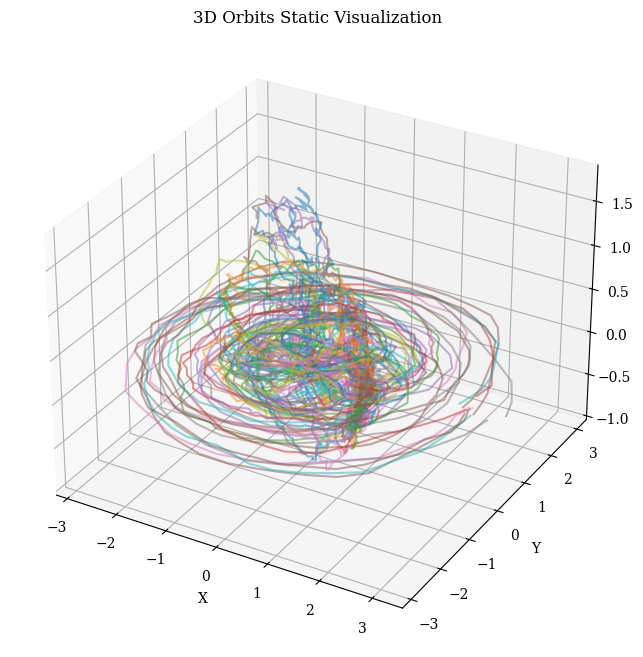

In [17]:
visualize_static_orbits(data= no_time_generation, show_legend=False, save_path=static_all_orbit_path)

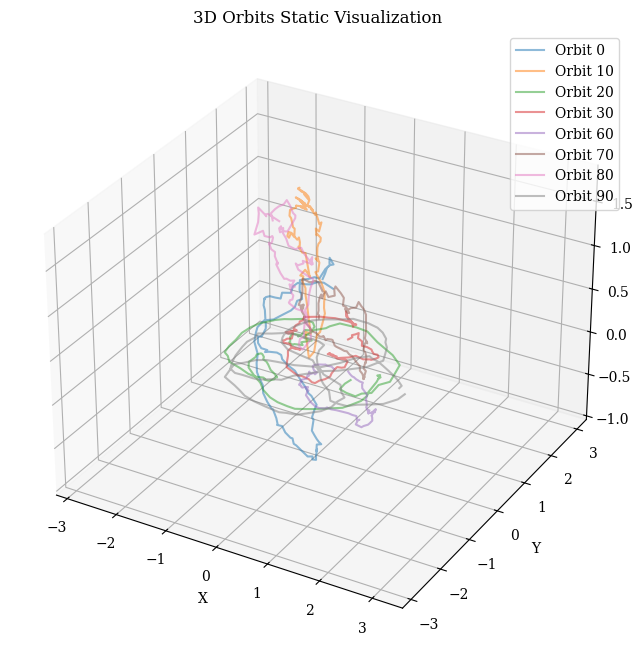

In [18]:
visualize_static_orbits(data= no_time_generation, orbit_indices=[0,10,20,30,60,70,80,90], save_path=static_some_orbit_path)

In [19]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_13/images/exp13_generated_orbits.html


## Coverage

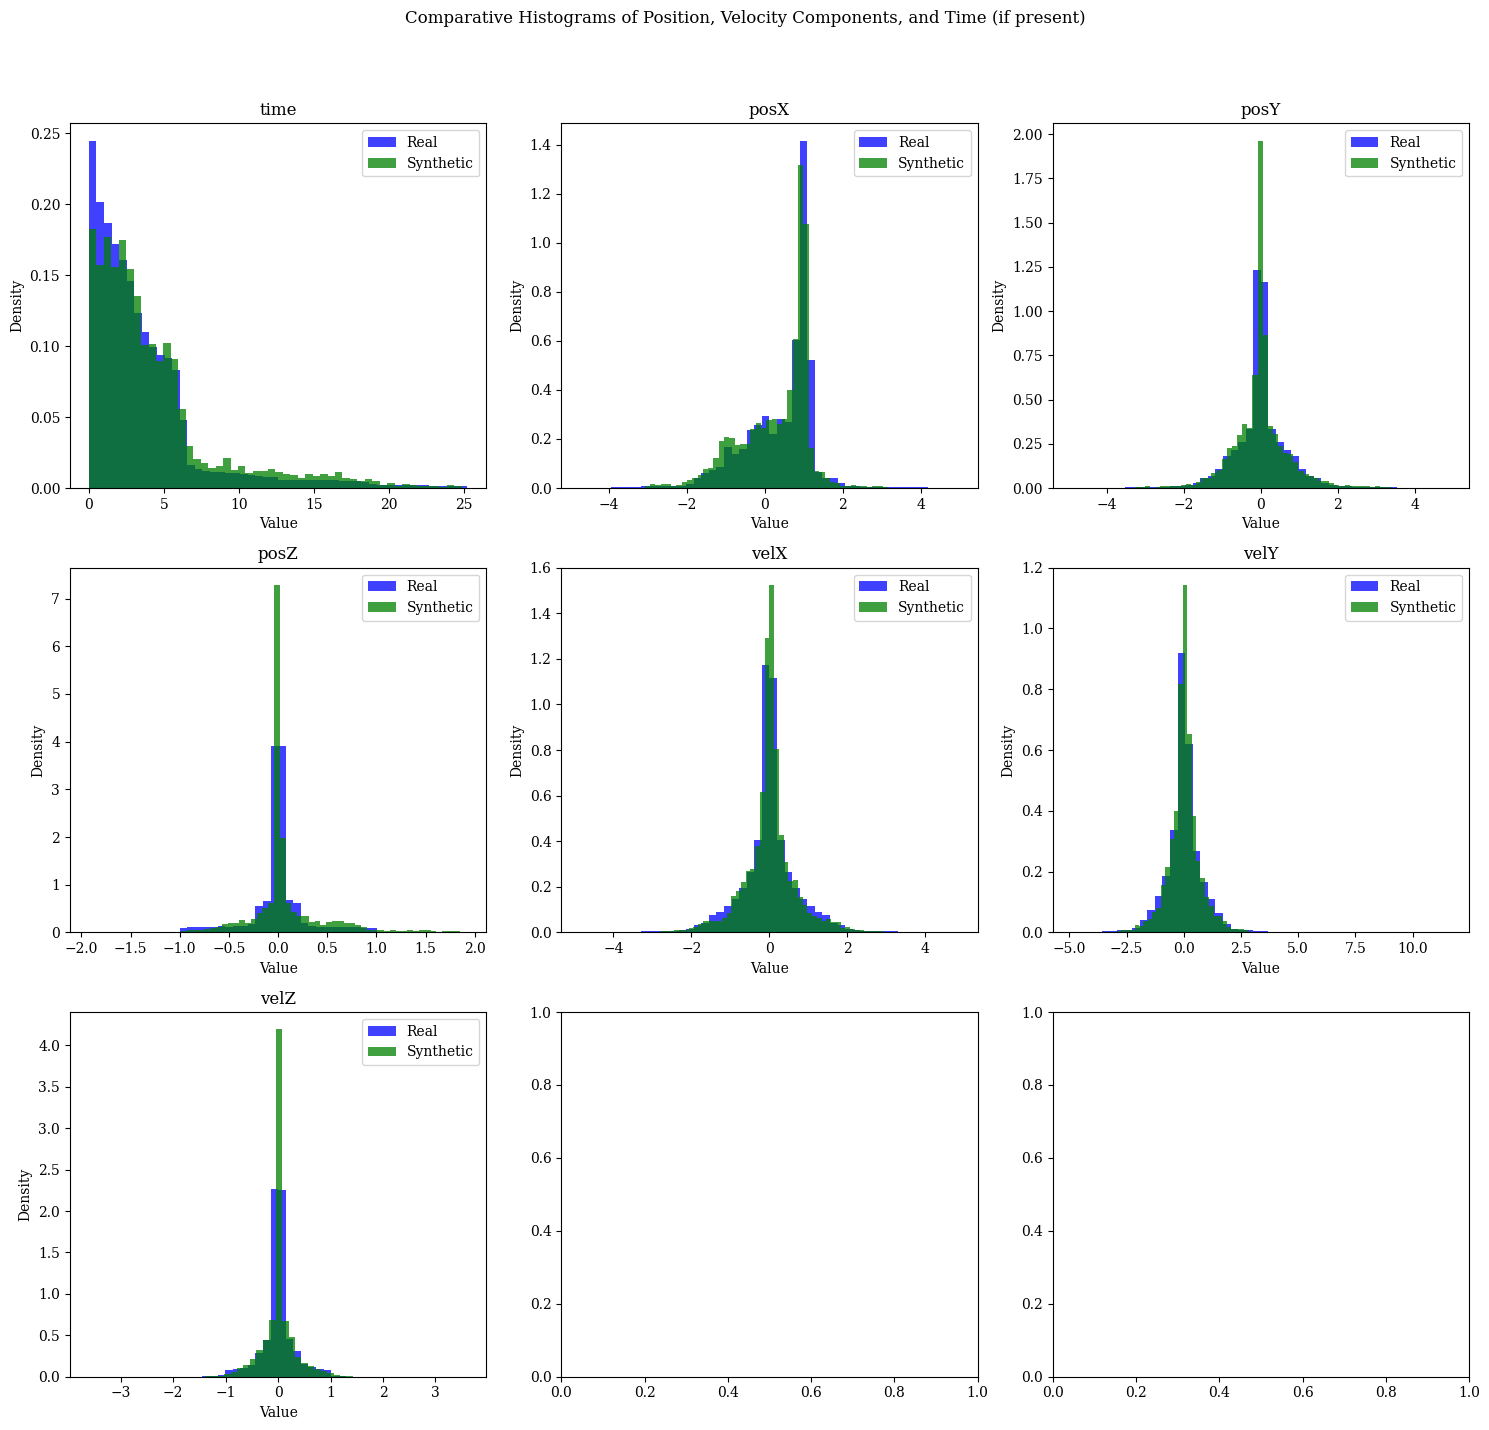

In [20]:
plot_histograms_comparison(data1=data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=histogram_comparison_path)

## Pheasibility

In [21]:
if calculate_error_metrics:
    reordered_generation, order_metrics = reorder_orbits(generation)
    per_orbit_errors = calculate_errors_per_orbit(reordered_generation,EM_MU)
    mean_errors = {key: np.mean(value) for key, value in per_orbit_errors.items()}
    add_experiment_metrics(experiments_folder, params=params, metrics={**mean_errors, **order_metrics})

Metrics added to experiment with ID 13 in ../experiments/experiments.json.


# Latent Space

In [22]:
latent_means, latent_log_vars = model.encode(scaled_data)
latent_means = latent_means.detach().numpy()
latent_log_vars = latent_log_vars.detach().numpy()
latent_representation = np.concatenate((latent_means, latent_log_vars), axis=1)
np.save(latent_representations_path, latent_representation)
latent_representation.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:304: UserWarning:

Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)



(45211, 4)

In [23]:
orbits_id_classes = [orbit_df.at[index, 'id_class'] for index in labels]
family_labels=get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

In [24]:
# Compute centroids
centroid_means = compute_centroids(latent_means, orbits_id_classes, method='mean')
centroid_log_vars = compute_centroids(latent_log_vars, orbits_id_classes, method='mean')
centroids_representation = np.concatenate((centroid_means, centroid_log_vars), axis=1)
np.save(family_centroids_path, centroids_representation)
centroids_representation.shape

(40, 4)

In [25]:
unique_classes = list(set(orbits_id_classes))
family_names=get_orbit_classes(unique_classes)[0]
len(family_names)

40

## Visualize

Dataset

Saved plot to ../experiments/experiment_13/images/exp13_latent_space


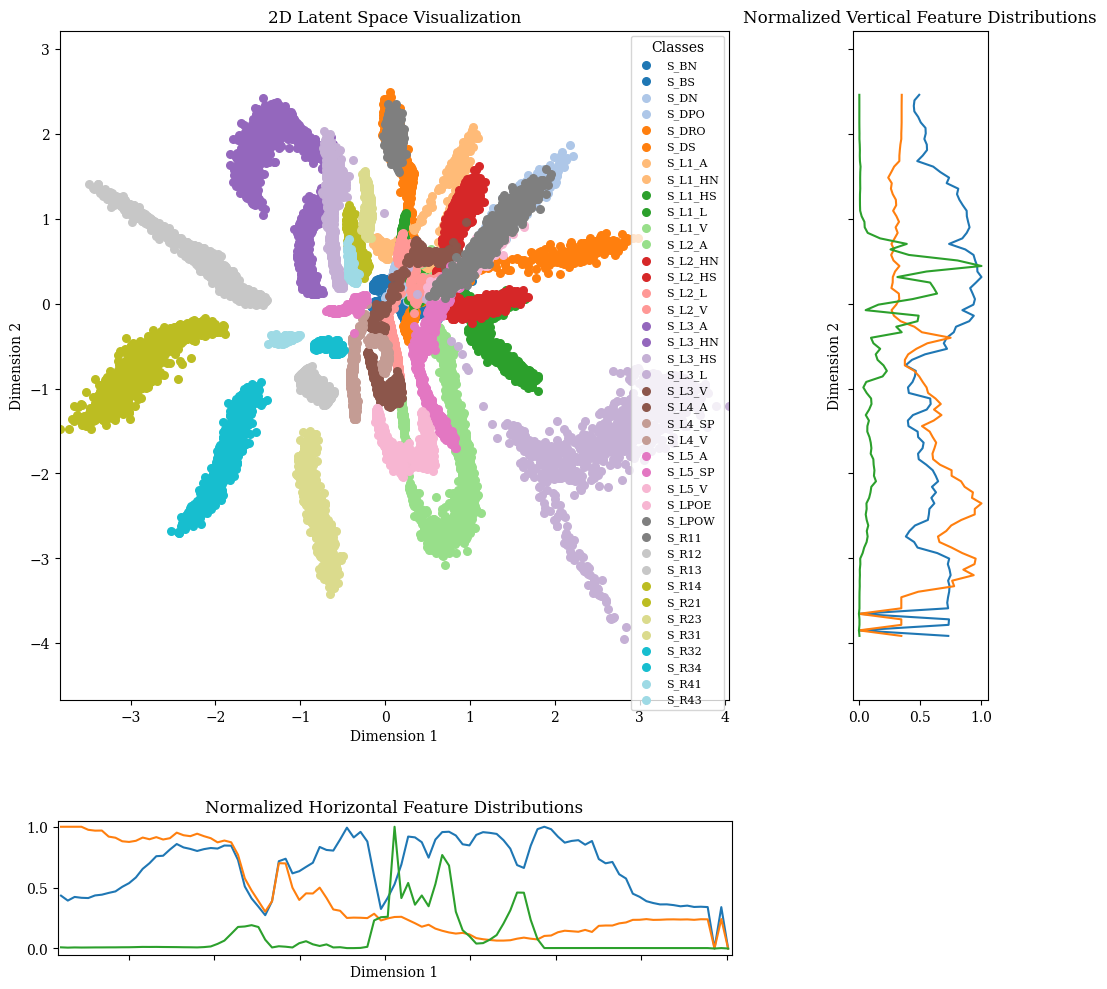

In [26]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(latent_means,
                            np.array(family_labels),
                            save_path=latent_space_path,
                            features=features,
                            feature_names=feature_names)
else:
    rls=reduce_dimensions_latent_space(latent_means,
                                        np.array(family_labels),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=latent_space_path,
                                        show_legend=False)

Centroids

Saved plot to ../experiments/experiment_13/images/exp13_family_centroids


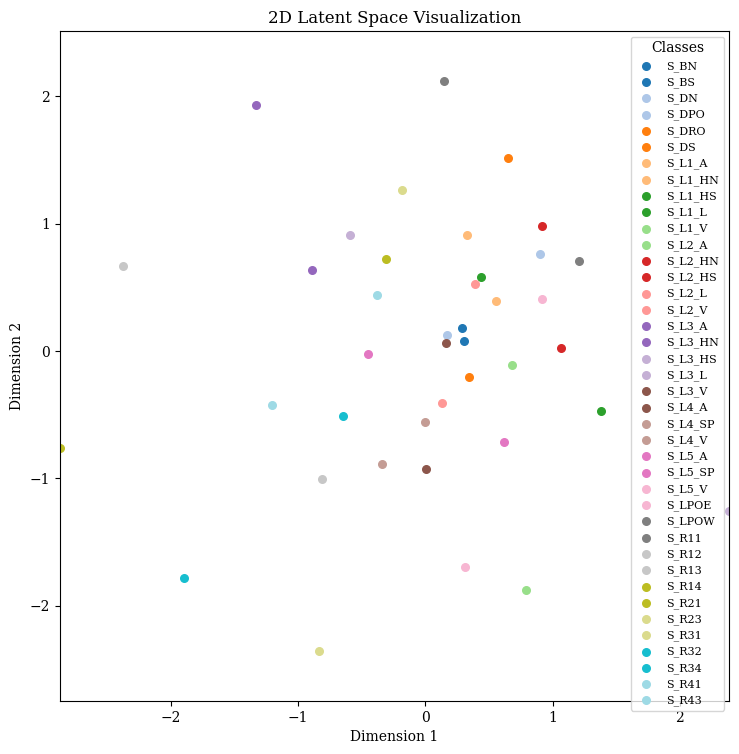

In [27]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(centroid_means,
                            np.array(family_names),
                            save_path=family_centroids_plot_path)
else:
    rls=reduce_dimensions_latent_space(centroid_means,
                                        np.array(family_names),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=family_centroids_plot_path,
                                        show_legend=False)

## Clustering

In [28]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_means, [family_labels], label_names=['family'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

Metrics added to experiment with ID 13 in ../experiments/experiments.json.


# Convergence

In [107]:
if want_to_perform_convergence:
    refined_orbits, refined_orbits_df= process_diferential_correction_orbits(np.transpose(reordered_generation,(0,2,1)),
                                                                        EM_MU,
                                                                        max_iter=params['max_iter_convergence'])
    refined_orbits = np.transpose(refined_orbits,(0,2,1))
    np.save(refined_data_path, refined_orbits)
else:
    refined_orbits = np.load(refined_data_path)

refined_orbits.shape

INFO:orbit_generation.convergence:Processing orbit 1/100
INFO:orbit_generation.convergence:Orbit 0: Success=1, Norm=1.7348635354496155e-10, Iterations=8
INFO:orbit_generation.convergence:Processing orbit 2/100
INFO:orbit_generation.convergence:Orbit 1: Success=-1, Norm=1.557329694974136e-14, Iterations=50
INFO:orbit_generation.convergence:Processing orbit 3/100
INFO:orbit_generation.convergence:Orbit 2: Success=-1, Norm=0.1790698109078228, Iterations=50
INFO:orbit_generation.convergence:Processing orbit 4/100
INFO:orbit_generation.convergence:Orbit 3: Success=-1, Norm=24.906400209164904, Iterations=2
INFO:orbit_generation.convergence:Processing orbit 5/100
INFO:orbit_generation.convergence:Orbit 4: Success=-1, Norm=12.240173870296509, Iterations=2
INFO:orbit_generation.convergence:Processing orbit 6/100
INFO:orbit_generation.convergence:Orbit 5: Success=-1, Norm=10.190070712489295, Iterations=4
INFO:orbit_generation.convergence:Processing orbit 7/100
INFO:orbit_generation.convergence:O

(39, 7, 100)

Test Convergence

In [114]:
reordered_refined_orbits, refined_order_metrics = reorder_orbits(refined_orbits)
refined_order_metrics

{'average_disorder_metric': np.float64(223.7948717948718),
 'percentage_correct_order': np.float64(74.43667443667444),
 'average_inversions': 143.46153846153845,
 'average_kendall_tau': np.float64(0.05796425796425781)}

In [81]:
refined_per_orbit_errors = calculate_errors_per_orbit(reordered_refined_orbits,EM_MU)
refined_orbits_df['propagated_position_error'] = refined_per_orbit_errors['position_error']
refined_orbits_df['propagated_velocity_error'] = refined_per_orbit_errors['velocity_error']
refined_orbits_df['propagated_energy_error'] = refined_per_orbit_errors['energy_error']
refined_mean_errors = {key: np.mean(value) for key, value in refined_per_orbit_errors.items()}
refined_mean_errors

In [76]:
generation_df = pd.DataFrame(per_orbit_errors)
generation_df.head()

,position_error,velocity_error,energy_error
0,0.176685,0.298400,0.971652
1,0.145966,0.319870,0.228754
2,0.063751,0.117086,0.088108
3,0.163273,0.692507,1.640612
4,0.233455,0.457178,0.589307


In [77]:
refined_orbits_df.head()

,id,old_period,new_period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,propagated_position_error,propagated_velocity_error,propagated_energy_error
0,0,6.371003,6.256383,8,3.830219e-11,0.275084,0.086442,0.914081,-0.035537,-0.890870,-0.047094,0.074164,-0.019819,9.924161e-01,-0.039777,-1.076208,-1.833668e-02,1.684003e-12,4.069955e-12,1.766712e-11
1,5,6.494525,6.221260,10,2.938881e-11,-1.233239,0.097310,1.466275,-0.059438,0.944021,0.022759,-1.088217,0.049838,1.494468e+00,0.043876,0.818570,-1.442144e-02,2.138521e-12,5.858956e-12,1.300436e-12
2,6,7.302292,5.416312,7,5.969081e-13,0.475225,-0.002014,-0.019515,0.225110,2.045272,0.016797,0.636853,-0.124488,1.091909e-13,-0.010826,0.806220,-1.656086e-14,3.816108e-12,7.830050e-12,6.871659e-13
3,7,6.412498,6.254594,12,1.685013e-11,0.042420,0.068655,0.916700,0.097492,-0.728307,-0.068786,-0.096459,-0.122167,9.844438e-01,-0.245395,-0.889715,-1.333308e-01,1.807277e-12,4.117426e-12,1.558907e-12
4,8,6.432546,6.310967,7,1.639853e-10,0.651503,-0.283360,0.609475,-0.368820,-1.239425,0.052132,0.629486,-0.497999,5.969923e-01,-1.104166,-1.419967,-9.501284e-03,3.144811e-12,1.272830e-11,1.769351e-10


In [32]:
refined_ids = refined_orbits_df['id'].astype(int).tolist()
generated_data_that_was_refined = generation[refined_ids]
generated_data_that_was_refined.shape

(40, 7, 100)

Generation that was able to get Refined

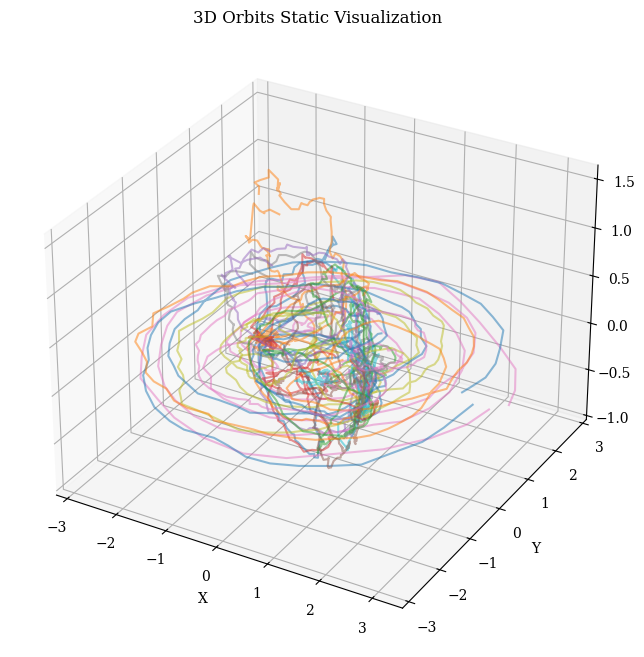

In [33]:
visualize_static_orbits(generated_data_that_was_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_converged_path)

Refinement

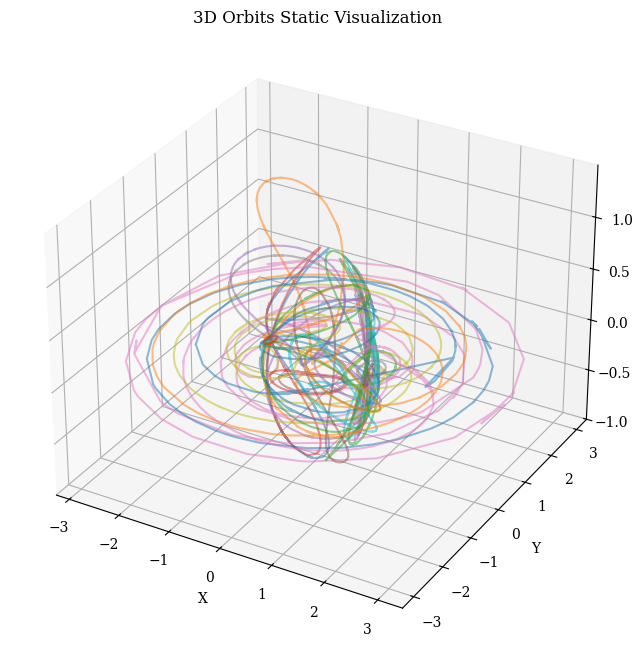

In [34]:
visualize_static_orbits(refined_orbits[:,1:,:], show_legend=False, save_path=refined_orbits_path)

Generation that didn't manage to get refined

In [35]:
non_refined_ids = sorted(set(range(params['samples_to_generate'])) - set(refined_ids))
generated_data_that_was_not_refined = generation[non_refined_ids]
generated_data_that_was_not_refined.shape

(60, 7, 100)

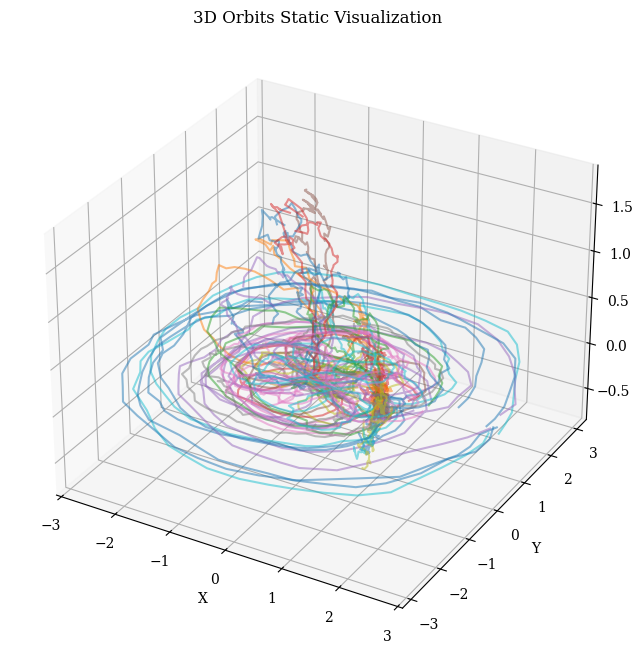

In [36]:
visualize_static_orbits(generated_data_that_was_not_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_did_not_converged_path)

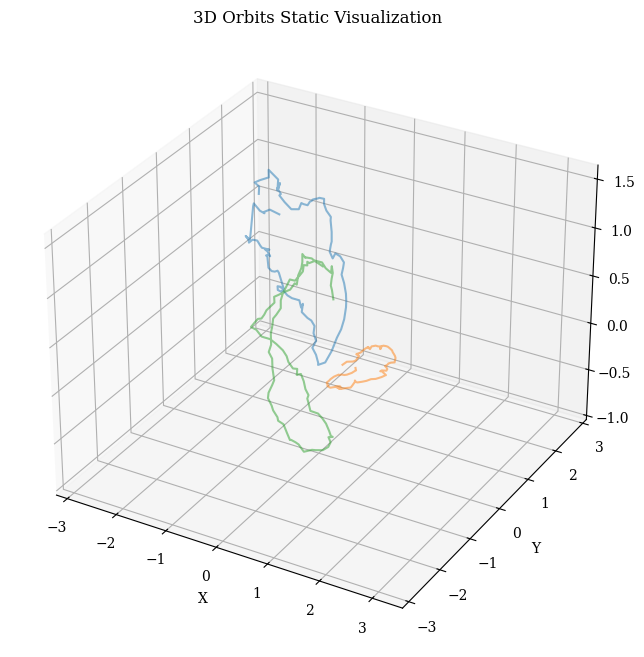

In [37]:
visualize_static_orbits(generated_data_that_was_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_converged_path, orbit_indices=[1,2,3])

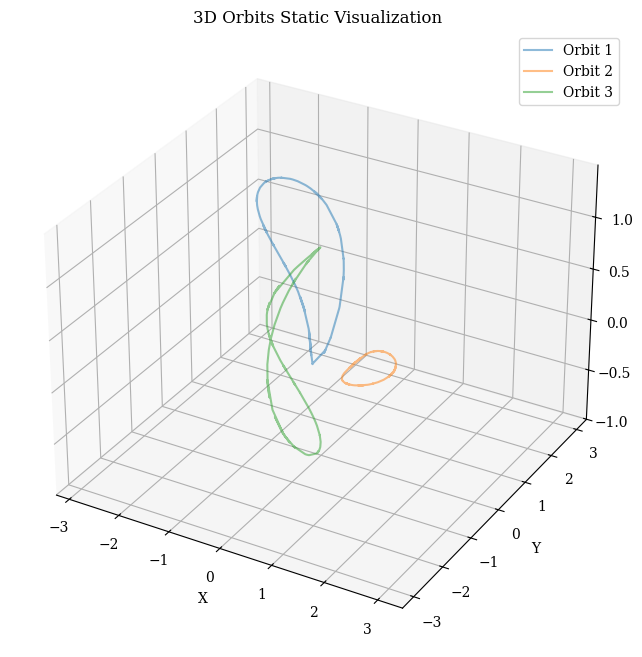

In [38]:
visualize_static_orbits(refined_orbits[:,1:,:], show_legend=True, save_path=refined_orbits_path, orbit_indices=[1,2,3])

## Latent Space

In [39]:
refined_scaled_data = scaler.transform(torch.from_numpy(refined_orbits).float())
refined_latent_means, refined_latent_log_vars = model.encode(refined_scaled_data)
refined_latent_representations = refined_latent_means.detach().numpy()
refined_latent_representations.shape

(40, 2)

Saved plot to ../experiments/experiment_13/images/exp13_combined_latent_space


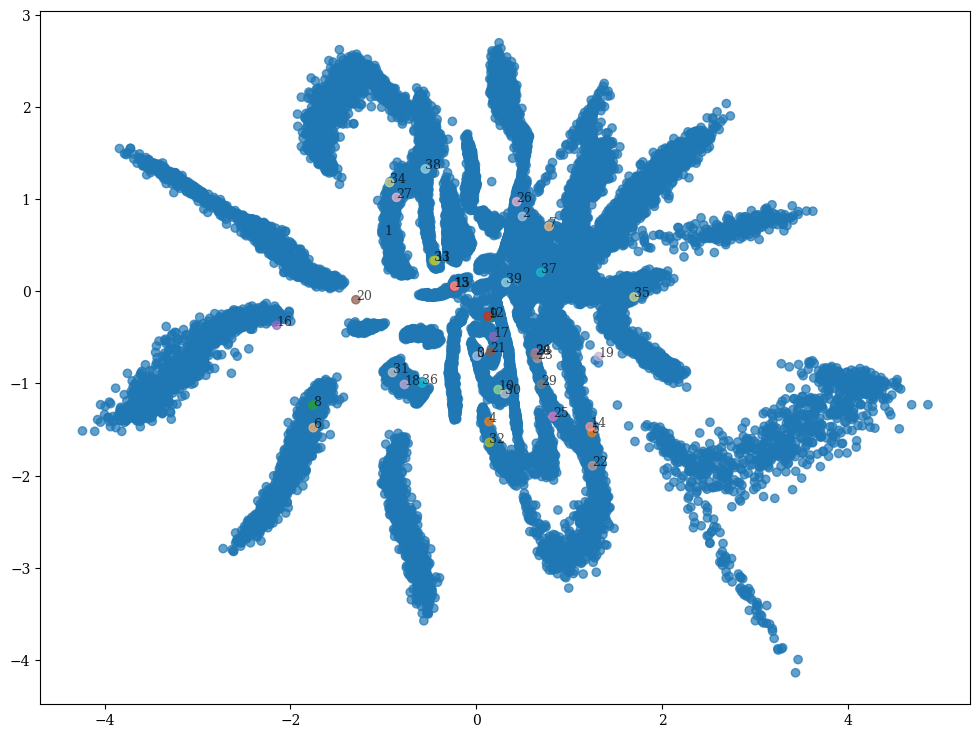

In [40]:
if refined_latent_representations.shape[1]>2:
    rls=reduce_dimensions_latent_space(train_latent=latent_representation,
                                        val_latent=refined_latent_representations)
    latent_representation=rls['PCA']['train']
    refined_latent_representations=rls['PCA']['val']

plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=refined_latent_representations,
    synthetic_labels=list(range(0, len(refined_scaled_data))),
    annotation_mode='numbers',
    save_path=combined_latent_space_path
)

In [41]:
### plot how far away we are from each convergence and generation in the latent space

## Check Novelty

Calculate Jacobi Constant on the dataset

In [42]:
results = np.array([jacobi_constant(np.transpose(data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(data.shape[0])])
orbit_df['calculated_jacobi'] = results

orbit_df.head()

,id_class,x_0,y_0,x_0,vx_0,vy_0,vz_0,jacobi,period,stability,propagated_periods,calculated_jacobi
0,1.0,0.941000,1.900442e-23,0.509474,2.968938e-13,-0.124968,-3.122717e-12,2.745412,11.555291,211.184678,3.0,2.757415
1,1.0,0.941538,-8.592698e-24,0.508602,2.902340e-13,-0.125672,-3.252212e-12,2.746226,11.551622,210.329145,3.0,2.758229
2,1.0,0.942076,6.956604e-24,0.507729,2.685527e-13,-0.126375,-2.862050e-12,2.747039,11.547936,209.473685,3.0,2.759042
3,1.0,0.942613,1.763946e-24,0.506856,3.153637e-13,-0.127078,-3.791054e-12,2.747850,11.544233,208.618315,3.0,2.759853
4,1.0,0.943150,9.441804e-24,0.505982,2.663322e-13,-0.127781,-2.982720e-12,2.748660,11.540511,207.763051,3.0,2.760663


Calculate Jacobi Constant and Period on the Refined Orbits

In [43]:
new_jacobis = np.array([jacobi_constant(np.transpose(refined_orbits[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(refined_orbits.shape[0])])
refined_orbits_df['calculated_jacobi'] = new_jacobis
refined_orbits_df.rename(columns={'new_period': 'period'}, inplace=True)
refined_orbits_df['period_distance_with_generation'] = abs(refined_orbits_df['period'] - refined_orbits_df['old_period'])
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,calculated_jacobi,period_distance_with_generation
0,0,6.371003,6.256383,8,3.830219e-11,0.275084,0.086442,0.914081,-0.035537,-0.890870,-0.047094,0.074164,-0.019819,9.924161e-01,-0.039777,-1.076208,-1.833668e-02,0.858684,0.114620
1,5,6.494525,6.221260,10,2.938881e-11,-1.233239,0.097310,1.466275,-0.059438,0.944021,0.022759,-1.088217,0.049838,1.494468e+00,0.043876,0.818570,-1.442144e-02,1.608455,0.273265
2,6,7.302292,5.416312,7,5.969081e-13,0.475225,-0.002014,-0.019515,0.225110,2.045272,0.016797,0.636853,-0.124488,1.091909e-13,-0.010826,0.806220,-1.656086e-14,2.837927,1.885979
3,7,6.412498,6.254594,12,1.685013e-11,0.042420,0.068655,0.916700,0.097492,-0.728307,-0.068786,-0.096459,-0.122167,9.844438e-01,-0.245395,-0.889715,-1.333308e-01,1.167666,0.157903
4,8,6.432546,6.310967,7,1.639853e-10,0.651503,-0.283360,0.609475,-0.368820,-1.239425,0.052132,0.629486,-0.497999,5.969923e-01,-1.104166,-1.419967,-9.501284e-03,-0.590950,0.121579


Compare Features between Dataset and Refinement

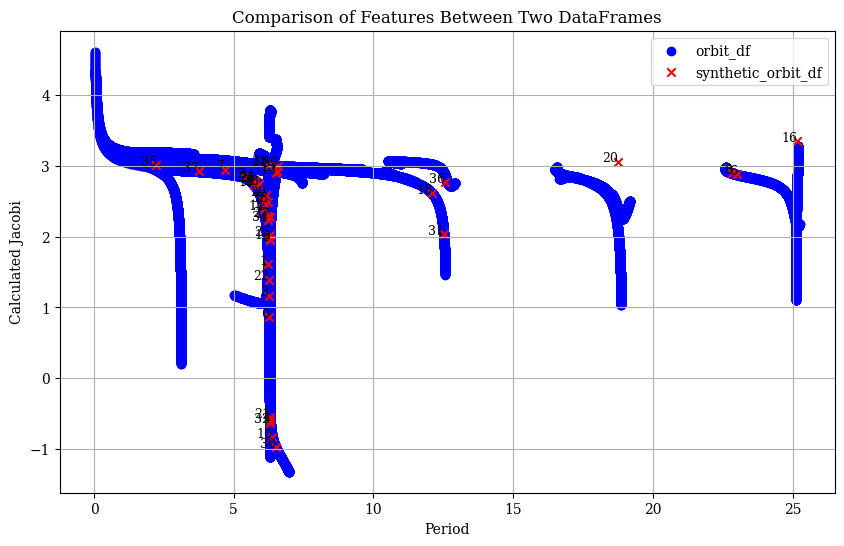

In [44]:
features = ['period', 'calculated_jacobi']

feature_distances = calculate_closest_feature_distances(orbit_df, refined_orbits_df, features)
refined_orbits_df['feature_distance_from_closest'] = feature_distances

## Calculate distances

In [45]:
if data.shape[1] == 7:
    no_time_data = data[:,1:,:]
    no_time_refined_orbits = refined_orbits[:,1:,:]
    no_time_generated_data_that_was_refined = generated_data_that_was_refined[:,1:,:]
else:
    no_time_data = data
    no_time_refined_orbits = refined_orbits
    no_time_generated_data_that_was_refined = generated_data_that_was_refined

print(no_time_data.shape)
print(no_time_refined_orbits.shape)
print(no_time_generated_data_that_was_refined.shape)
print(no_time_generation.shape)


(45211, 6, 100)
(40, 6, 100)
(40, 6, 100)
(100, 6, 100)


In [46]:
no_time_generation.shape

(100, 6, 100)

In [47]:
no_time_data.shape

(45211, 6, 100)

In [48]:
nearest_indices_generation, nearest_distances_generation = find_nearest_orbits_batch(no_time_generation,
                                                                                     no_time_data,
                                                                                     n=1,
                                                                                     distance_metric=params['distance_metric'])
generation_df['nearest_orbit'] = nearest_indices_generation
generation_df['nearest_orbit_distance'] = nearest_distances_generation
generation_df.head()

,position_error,velocity_error,energy_error,nearest_orbit,nearest_orbit_distance
0,0.176685,0.298400,0.971652,0,21.681069
1,0.145966,0.319870,0.228754,0,8.449480
2,0.063751,0.117086,0.088108,0,6.276772
3,0.163273,0.692507,1.640612,0,13.006234
4,0.233455,0.457178,0.589307,0,16.624334


In [49]:
nearest_indices_refined_generation, nearest_distances_refined_generation = find_nearest_orbits_batch(no_time_refined_orbits,
                                                                                                     no_time_data,
                                                                                                     n=1,
                                                                                                     distance_metric=params['distance_metric'])
refined_orbits_df['nearest_orbit'] = nearest_indices_refined_generation
refined_orbits_df['nearest_orbit_distance'] = nearest_distances_refined_generation

In [50]:
pairwise_distances = calculate_pairwise_distances(no_time_generated_data_that_was_refined,
                                                  no_time_refined_orbits,
                                                  distance_metric=params['distance_metric'])
refined_orbits_df['distance_from_generation'] = pairwise_distances
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,...,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,calculated_jacobi,period_distance_with_generation,feature_distance_from_closest,nearest_orbit,nearest_orbit_distance,distance_from_generation
0,0,6.371003,6.256383,8,3.830219e-11,0.275084,0.086442,0.914081,-0.035537,-0.890870,...,9.924161e-01,-0.039777,-1.076208,-1.833668e-02,0.858684,0.114620,0.001923,0,21.477709,2.670264
1,5,6.494525,6.221260,10,2.938881e-11,-1.233239,0.097310,1.466275,-0.059438,0.944021,...,1.494468e+00,0.043876,0.818570,-1.442144e-02,1.608455,0.273265,0.001043,0,23.614485,3.721165
2,6,7.302292,5.416312,7,5.969081e-13,0.475225,-0.002014,-0.019515,0.225110,2.045272,...,1.091909e-13,-0.010826,0.806220,-1.656086e-14,2.837927,1.885979,0.003237,0,9.375256,2.666966
3,7,6.412498,6.254594,12,1.685013e-11,0.042420,0.068655,0.916700,0.097492,-0.728307,...,9.844438e-01,-0.245395,-0.889715,-1.333308e-01,1.167666,0.157903,0.002364,0,20.821136,3.950311
4,8,6.432546,6.310967,7,1.639853e-10,0.651503,-0.283360,0.609475,-0.368820,-1.239425,...,5.969923e-01,-1.104166,-1.419967,-9.501284e-03,-0.590950,0.121579,0.000160,0,23.585131,3.411635


In [51]:
### distance from the centre

In [52]:
#### distance from closest centroid

Export Features

In [53]:
def save_or_load_dataframe(df, path):
    if not os.path.exists(path):
        df.to_csv(path, index=False)  # Save the DataFrame
        return 'DataFrame saved.'
    else:
        return pd.read_csv(path)  # Load the DataFrame

In [54]:
generation_df = save_or_load_dataframe(generation_df, generation_df_path)
generation_df.head()

,position_error,velocity_error,energy_error,nearest_orbit,nearest_orbit_distance
0,0.058274,0.159461,0.083449,0,6.187284
1,0.025953,0.202844,0.247173,0,5.986574
2,0.121643,0.172019,0.113463,0,8.561216
3,0.468296,0.855176,0.987968,0,23.590916
4,0.385281,0.665945,0.604277,0,23.246072


In [55]:
refined_orbits_df = save_or_load_dataframe(refined_orbits_df, refined_orbits_df_path)
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,...,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,calculated_jacobi,period_distance_with_generation,feature_distance_from_closest,nearest_orbit,nearest_orbit_distance,distance_from_generation
0,2,9.848737,10.287466,8,5.273384e-11,0.992560,-0.019503,-0.215422,0.036667,-0.055961,...,-0.298621,-0.107077,-0.207206,0.141610,2.890764,0.438729,0.003645,0,8.263415,2.529646
1,3,6.328577,6.310875,12,6.605200e-13,1.096870,0.016677,0.121494,-0.098122,-1.588580,...,0.516034,-0.585410,-1.683870,-0.343422,-0.557010,0.017702,0.000174,0,23.860918,6.288731
2,4,5.689506,6.310907,8,2.766321e-13,0.493380,-0.220545,0.558166,-0.624320,-0.791176,...,0.611060,-1.134784,-1.381253,0.024482,-0.568755,0.621401,0.000254,0,23.614165,3.456566
3,5,17.601694,25.103259,31,2.359544e-10,0.906333,0.036489,0.014459,0.140044,0.471782,...,0.932661,-0.800712,-0.519702,0.249131,2.167103,7.501564,0.025138,0,20.324397,17.723887
4,6,6.681151,6.251575,9,5.101908e-10,-0.475964,0.125563,0.892033,0.061888,-0.216098,...,0.853038,-0.060840,-0.479980,-0.053919,2.049546,0.429576,0.001051,0,20.372405,2.521095


# Intelligent Sampling

In [56]:
# interpolate_sample(centroids, granularity=10, variance=0.0)